Вывод формул

a - a short
b - a long
w - w
t - t

Дано: $r, k$

$r=\frac{a}{b}; k=\frac{t}{w}$

как получить $a, b, t, w$?

Пусть длина стороны треугольника основания призмы 1

$b = \frac{1}{2r+1}$

$a = r \cdot b$

$w = \frac{\sqrt{3}}{2}(1-a)$

$t = k \cdot w$

In [1]:
import numpy as np
from random import random, uniform, randint
from matplotlib import pyplot as plt
import pandas as pd


from calc import distance, intersection, parallel, angle, orthogonal
from draw import draw
from line import Line
from plane import Plane
from point import Point
from solver import solve
from vector import Vector

__all__ = (
    "Line",
    "Plane",
    "Point",
    "Vector",
    "angle",
    "distance",
    "draw",
    "intersection",
    "orthogonal",
    "parallel",
    "solve",
)

In [2]:
def get_angles(points):
    # вычисление угла
    cnt = points
    num_points = len(cnt)
    angles = []
    for i, point in enumerate(cnt):
        point1 = cnt[i - 1]
        point2 = cnt[i]
        point3 = cnt[(i + 1) % num_points]
        angles.append(int(Vector(point2, point1).angle(Vector(point2, point3))* 180 / np.pi))

    return np.array(angles)

class Cube():
    #куб с вершиной А в нуле координат и заданной длиной ребра, находится в первой полуплоскости для каждй пары осей
    def __init__(self, side=1, center=Point(0.5, 0.5, 0.5)):
        
        
        self.side = side
        self.center = center
        a = side
        
        vec = Point(center - Point(side/2, side/2, side/2))
        
        self.A = Point(0, 0, 0) + vec
        self.B = Point(a, 0, 0) + vec
        self.C = Point(a, a, 0) + vec
        self.D = Point(0, a, 0) + vec
        self.E = Point(0, 0, a) + vec
        self.F = Point(a, 0, a) + vec
        self.G = Point(a, a, a) + vec
        self.H = Point(0, a, a) + vec
        
        self.iterable_points = [self.A, self.B, self.C, self.D, self.E, self.F, self.G, self.H]
        self.names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
        
        self.AB = Line(self.A, self.B)
        self.BC = Line(self.B, self.C)
        self.AD = Line(self.A, self.D)
        self.DC = Line(self.D, self.C)
        
        self.AE = Line(self.A, self.E)
        self.BF = Line(self.B, self.F)
        self.CG = Line(self.C, self.G)
        self.DH = Line(self.D, self.H)
        
        self.EF = Line(self.E, self.F)
        self.EH = Line(self.E, self.H)
        self.FG = Line(self.F, self.G)
        self.HG = Line(self.H, self.G)
        
        self.iterable_edges = [self.AB, self.BC, self.AD, self.DC, self.AE, self.BF,
                               self.CG, self.DH, self.EF, self.EH, self.FG, self.HG]
        
        
        
    def intersection_with_plane(self, plane):
        boundaries = self.iterable_edges

        intersections = filter(None, map(lambda edge: intersection(edge, plane), boundaries))
        intersections = filter(lambda x: not isinstance(x, Line), intersections)
        intersections = list(set(intersections))

        # Filter out any out of bounds intersections
        def in_bounds(point):
            # intersect is actually (num, point)
            return (
                # <3 Python's comparison operator
                self.A.x <= point.x <= self.G.x and
                self.A.y <= point.y <= self.G.y and
                self.A.z <= point.z <= self.G.z
            )
        intersections = list(filter(in_bounds, intersections))
        
        
        if intersections:
            polygon = [intersections.pop()]
            while intersections:
                last = polygon[-1]
                distances = [distance(last, x) for x in intersections]
                # We're only interested in the index of the next point,
                # this min function returns the minimum (index, distance)
                # tuple...
                successor = min(enumerate(distances), key=lambda x: x[1])
                # ...but we only need the index :)
                successor = successor[0]
                polygon.append(intersections.pop(successor))

            return polygon
        else:
            return []


    def is_point_in_truncated_triangle(point, r, k):
        a, b, w, t = from_rk_to_abwt(r, k)
        polygon = [Point(self.a, 0, 0), Point(self.a+self.b, 0, 0), Point(1.5*self.a+self.b, 3**0.5/2*self.a, 0),
                  Point(0.5+self.a, self.w, 0), Point(0.5-self.a, self.w, 0), Point(0.5*self.a, 3**0.5/2*self.a, 0)]
        #проверяем равенство площадей
        S = 3**0.5/4-3*3**0.5/4*a**2
        pA = polygon[0]
        pB = polygon[1]
        pC = polygon[2]
        pD = polygon[3]
        pE = polygon[4]
        pF = polygon[5]
        S1 = S_from_triangle([pA, pB, point])
        S2 = S_from_triangle([pB, pC, point])
        S3 = S_from_triangle([pC, pD, point])
        S4 = S_from_triangle([pD, pE, point])
        S5 = S_from_triangle([pE, pF, point])
        S6 = S_from_triangle([pF, pA, point])
        if abs(S-S1-S2-S3-S4-S5-S6) < 0.0001:
            return True
        else:
            return False

In [3]:
def from_rk_to_abwt(r, k):
    b = 1/(2*r+1)
    a = r*b
    w = 3**0.5/2*(1-a)
    t = k*w
    return a, b, w, t


right_triangle = [Point(0, 0, 0), Point(1, 0, 0), Point(0.5, 3**0.5/2, 0)]
        
def S_from_triangle(triangle):
    x1 = triangle[0][0]
    y1 = triangle[0][1]
    x2 = triangle[1][0]
    y2 = triangle[1][1]    
    x3 = triangle[2][0]
    y3 = triangle[2][1]
    return 0.5*abs((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1))




class WCCoPrism():
    #Правильная треугольная призма, 
    def __init__(self, r, k):
        
        self.a, self.b, self.w, self.t = from_rk_to_abwt(r, k)
        
        
        self.A = Point(self.a, 0, 0)
        self.B = Point(self.a+self.b, 0, 0)
        self.C = Point(1.5*self.a+self.b, 3**0.5/2*self.a, 0)
        self.D = Point(0.5+self.a/2, self.w, 0)
        self.E = Point(0.5-self.a/2, self.w, 0)
        self.F = Point(0.5*self.a, 3**0.5/2*self.a, 0)
        
        self.G = Point(self.a, 0, self.t)
        self.H = Point(self.a+self.b, 0, self.t)
        self.I = Point(1.5*self.a+self.b, 3**0.5/2*self.a, self.t)
        self.J = Point(0.5+self.a/2, self.w, self.t)
        self.K = Point(0.5-self.a/2, self.w, self.t)
        self.L = Point(0.5*self.a, 3**0.5/2*self.a, self.t)
        
        
        self.iterable_points = [self.A, self.B, self.C, self.D, self.E, self.F,
                               self.G, self.H, self.I, self.J, self.K, self.L]
        self.names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
        
        self.AB = Line(self.A, self.B)
        self.BC = Line(self.B, self.C)
        self.CD = Line(self.C, self.D)
        self.DE = Line(self.D, self.E)
        self.EF = Line(self.E, self.F)
        self.FA = Line(self.F, self.A)
        
        self.AG = Line(self.A, self.G)
        self.BH = Line(self.B, self.H)
        self.CI = Line(self.C, self.I) 
        self.DJ = Line(self.D, self.J)
        self.EK = Line(self.E, self.K)
        self.FL = Line(self.F, self.L) 
        
        self.GH = Line(self.G, self.H)
        self.HI = Line(self.H, self.I)
        self.IJ = Line(self.I, self.J)
        self.JK = Line(self.J, self.K)
        self.KL = Line(self.K, self.L)
        self.LG = Line(self.L, self.G)
        
        self.ABC = Plane(self.A, self.B, self.C)
        self.GHI = Plane(self.G, self.H, self.I)
        
        self.ABH = Plane(self.A, self.B, self.H)
        self.BCH = Plane(self.B, self.C, self.H)
        self.CDJ = Plane(self.C, self.D, self.J)
        self.DEK = Plane(self.D, self.E, self.K)
        self.EFL = Plane(self.E, self.F, self.L)
        self.FAG = Plane(self.F, self.A, self.G)
        

        
        self.iterable_edges = [self.AB, self.BC, self.CD, self.DE, self.EF, self.FA,
                               self.AG, self.BH, self.CI, self.DJ, self.EK, self.FL, 
                               self.GH, self.HI, self.IJ, self.JK, self.KL, self.LG]
        
        self.iterable_facets = [self.ABC, self.GHI, self.ABH, self.BCH, 
                                self.CDJ, self.DEK, self.EFL, self.FAG]
        
    def is_point_in_truncated_triangle(self, point):
        polygon = [self.A, self.B, self.C, self.D, self.E, self.F, self.G]
        #проверяем равенство площадей
        S = 3**0.5/4-3*3**0.5/4*self.a**2
        pA = polygon[0]
        pB = polygon[1]
        pC = polygon[2]
        pD = polygon[3]
        pE = polygon[4]
        pF = polygon[5]
        S1 = S_from_triangle([pA, pB, point])
        S2 = S_from_triangle([pB, pC, point])
        S3 = S_from_triangle([pC, pD, point])
        S4 = S_from_triangle([pD, pE, point])
        S5 = S_from_triangle([pE, pF, point])
        S6 = S_from_triangle([pF, pA, point])
        if abs(S-S1-S2-S3-S4-S5-S6) < 0.000001:
            return True
        else:
            return False
        
        
    def intersection_with_plane(self, plane):
        boundaries = self.iterable_edges

        intersections = filter(None, map(lambda edge: intersection(edge, plane), boundaries))
        intersections = filter(lambda x: not isinstance(x, Line), intersections)
        intersections = list(set(intersections))

        # Filter out any out of bounds intersections
        def in_bounds(point):
            #right_triangle = [self.A, self.B, self.C]
            # intersect is actually (num, point)
            return (
                self.is_point_in_truncated_triangle(point=point)
                and 0 <= point.z <= self.t
            )
        
        intersections = list(filter(in_bounds, intersections))
        #print('problem not here')
        
        if intersections:
            #print(intersections)
            point = intersections[0]
            polygon = []
            polygon.append(point)
            del intersections[0]
            
            uu_kostyl = 0 

            while intersections:
                for i, p in enumerate(intersections):
                    uu_kostyl += 1
                    flag = False
                    for plane in self.iterable_facets:
                        if (p in plane) and (point in plane):
                            polygon.append(p)
                            del intersections[i]
                            point = p
                            flag = True
                            break
                    if flag:
                        break
                if uu_kostyl > 1000:
                    print('i had a problem with precision')
                    return []
            #print(polygon)
            return polygon
        else:
            #print('[]')
            return []

In [7]:
def make_random_plane(n=1):
    #в кубе с левой нижней вершиной 0,0,0 а правой верхней n,n,n
    center = Point(n/2, n/2, n/2)
    cube = Cube(side=n, center=center)
    #генерируем два угла k1 и k2
    k1, k2 = np.tan(uniform(0, np.pi)), np.tan(uniform(0, np.pi))
    #рассматриваем случаи
    if k1 >= 0:
        xm = 0
        ym = 0
    else:
        xm = n
        ym = n
        k1 = -k1
    m1 = n/2-2**(0.5)/2*n*k1
    v1 = Vector(center, Point(xm, ym, m1))
    
    if k2 >= 0:
        xn = 0
        yn = n
    else:
        xn = n
        yn = 0
        k2 = -k2
    m2 = n/2-2**(0.5)/2*n*k2
    v2 = Vector(center, Point(xn, yn, m2))
    
    #m1 и m2 - потенциальные минимумы
    
    if m1 <= m2:
        x = xm
        y = ym
        m = m1
    else:
        x = xn
        y = yn
        m = m2
    
    #генерируем "сдвиг"
    z = uniform(2*m - n, n)
    #возвращаем плоскость по точке и двум векторам
    return Plane(Point(x, y, z), v1, v2)


def generate_random_plane_angles(cube, r, k):
    a, b, w, t = from_rk_to_abwt(r, k)
    plane = make_random_plane(n=max(1, t))
    #до сюда доходит
    points_intersection = cube.intersection_with_plane(plane)
    #до сюда нет
    #print("i found points_intersection")
    if len(points_intersection) != 0:
        return get_angles(points_intersection)
    else:
        return []
    
def generates_n_plates(cube, r, k, n=1000):
    
    angles = [0]*181
    
    for i in range(n):
        angs = generate_random_plane_angles(cube, r, k)
        if len(angs) != 0:
            for ang in angs:
                angles[ang] += 1
    
    return list(np.array(angles)/np.sum(angles))

def generate_vertex_distribution(cube, r, k, n=1000):
    
    vertex = [0]*10
    for i in range(n):
        angs = generate_random_plane_angles(cube, r, k)
        vertex[len(angs)] += 1
    
    return vertex

def make_table_vertex_distribution(cube, r, k, n=1000, n_try=10):
    vertex_distrs = []
    for i in range(n_try):
        vertex_distrs.append(generate_vertex_distribution(cube=cube, r=r, k=k, n=n))

    vertex_distrs = np.array(vertex_distrs)
    vertex_distrs[:, 0] = 0
    vertex_distrs = vertex_distrs/np.sum(vertex_distrs, axis=1)[:,None]*100
    mean = np.mean(vertex_distrs, axis=0)
    std = np.std(vertex_distrs, axis=0)
    var = np.var(vertex_distrs, axis=0)
    
    indexes = list(range(1, n_try+1)) + ['mean', 'std', 'dispersion']
    return pd.DataFrame(np.vstack((vertex_distrs, mean, std, var)), index=indexes)

i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i got a problem with arccos V

i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i had a problem with precision
i had a problem with precision
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i had a problem with precision
i had a problem with precision
i had a problem with precision
i got a problem with arccos Vector(-1.63

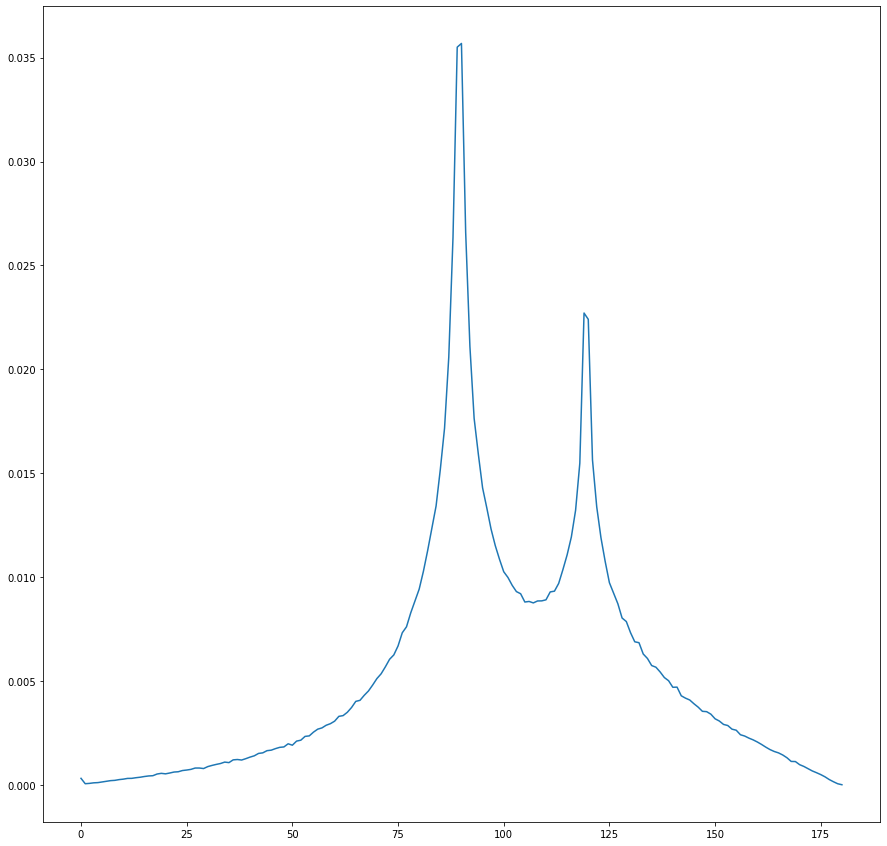

Wall time: 13min 28s


In [5]:
%%time
plt.figure(figsize=(15,15))
plt.plot(generates_n_plates(WCCoPrism(0.6, 0.9), 0.6, 0.9, 500000))
plt.savefig("WC-Co-model-r-0.6-k-0.9.png", dpi=300)
plt.show()

In [8]:
vertex_distr = make_table_vertex_distribution(cube=WCCoPrism(0.6, 0.9), r=0.6, k=0.9, n=10000, n_try=10)
vertex_distr.to_csv('WC-Co-r-0.6-k-0.9_vertex_distr.csv')

i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i had a problem with precision
i had a problem with precision
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem wit

In [9]:
vertex_distr

,0,1,2,3,4,5,6,7,8,9
1,0.0,0.018437,0.036873,14.030236,37.278761,24.926254,19.948378,3.595133,0.165929,0.0
2,0.0,0.018681,0.000000,15.075659,35.811694,24.957967,19.839342,3.997758,0.298898,0.0
3,0.0,0.000000,0.018543,14.407565,36.454663,25.329130,20.081587,3.430373,0.278138,0.0
4,0.0,0.000000,0.000000,15.007348,37.454078,24.650992,18.919912,3.710507,0.257164,0.0
5,0.0,0.000000,0.000000,15.832711,36.669156,24.626587,19.342793,3.304705,0.224048,0.0
6,0.0,0.000000,0.000000,14.812745,37.823738,23.812186,20.085709,3.074343,0.391280,0.0
7,0.0,0.000000,0.000000,14.910314,37.649477,24.177877,19.431988,3.400598,0.429746,0.0
8,0.0,0.000000,0.037313,15.130597,37.444030,23.880597,19.552239,3.619403,0.335821,0.0
9,0.0,0.000000,0.000000,14.702061,37.627622,23.853722,19.491368,3.898274,0.426954,0.0
10,0.0,0.018508,0.037016,14.825097,37.701277,24.597446,19.267074,3.257450,0.296132,0.0
